In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import use
from scipy.integrate import solve_ivp
from scipy.signal import square

from model import odefun_3mass_full_pars, odefun_3mass_full_inputs, dummy
from motor import schiffer_motor, odefun_dc_motor
from torque_splitter import V_dist

# 2-mass system

In [6]:
def odefun_2mass(t, y, Jm, cm, Jl, cl, ks, cs, alpha, Tm1_func, Tm2_func):
    wm, wl, thm, thl, thd, thb = y
    Tm1 = Tm1_func(t)
    Tm2 = Tm2_func(t)

    wd = wm - wl

    if thb <= -alpha:
        wb = max(0, wd + (ks/cs) * (thd - thb))
    elif np.abs(thb) < alpha:
        wb = wd + (ks/cs) * (thd - thb)
    elif thb >= alpha:
        wb = min(0, wd + (ks/cs) * (thd - thb))

    if (thb == -alpha and wb > 0) or (np.abs(thb) < alpha) or (thb == alpha and wb < 0):
        backlash = True
    else:
        backlash = False

    Ts = 0 if backlash else ks * (thd - thb) + cs * wd

    dwm_dt = (-cm * wm - Ts + Tm1) / Jm
    dwl_dt = (-cl * wl + Ts + Tm2) / Jl
    thm_dt = wm
    thl_dt = wl
    thd_dt = wd
    thb_dt = wb

    return [dwm_dt, dwl_dt, thm_dt, thl_dt, thd_dt, thb_dt]

In [7]:
Jm = 0.4 # kg m^2
cm = 0.1 # N * m / (rad/s)
Jl = 5.6 # kg m^2
cl = 1 # N * m / (rad/s)
ks = 10*3300 # N * m / rad
cs = 100*1 # N * m / (rad/s)
rl = 0.01 # m
alpha = np.deg2rad(5) # rad TODO: make sure it has to be in radians

def Tm1_func(t):
    return np.sin(np.pi * t)

def Tm2_func(t):
    return 0 #if t < 2 else -0.9

t_span = [0, 5]
t_eval = np.linspace(*t_span, 10000)
# wm, wl, thm, thl, thd, thb
y0 = [0, 0, 0, 0, 0, 0]
sol = solve_ivp(odefun_2mass, t_span=t_span, t_eval=t_eval, y0=y0, args=(Jm, cm, Jl, cl, ks, cs, alpha, Tm1_func, Tm2_func)
                # ,dense_output=True
                )

In [8]:
use(backend='TkAgg')

plt.figure(figsize=(12,8))
ax1 = plt.subplot(3, 1, 1)
ax1.plot(sol.t, sol.y[0,:], label='Motor speed')
ax1.plot(sol.t, sol.y[1,:], label='Load speed')
ax1.legend(); ax1.grid()
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(sol.t, np.rad2deg(sol.y[2,:]), label='Motor angle')
ax2.plot(sol.t, np.rad2deg(sol.y[3,:]), label='Load angle')
ax2.legend(); ax2.grid()
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(sol.t, np.rad2deg(sol.y[4,:]), label='Delta angle')
ax3.plot(sol.t, np.rad2deg(sol.y[5,:]), label='Backlash angle')
ax3.plot(sol.t, np.vectorize(Tm1_func)(sol.t), label='Motor torque')
ax3.plot(sol.t, np.vectorize(Tm2_func)(sol.t), label='Load torque')
ax3.legend(); ax3.grid()
plt.tight_layout()
plt.show()

# 3-mass system

In [ ]:
Jl = 5.6 # kg m^2
cl = 1 # N * m / (rad/s)
ks = 10*3300 # N * m / rad
cs = 100*1 # N * m / (rad/s)
rl = 0.01 # m
alpha1 = alpha2 = np.deg2rad(1) # rad

def V1_func(t):
    frequency = 0.5 # Hertz
    amplitude = 10 # Volts
    phase_angle = 0 # degrees
    return V_dist(amplitude * np.sin(2 * np.pi * frequency * t + np.deg2rad(phase_angle)))[0]

def V2_func(t):
    frequency = 0.5 # Hertz
    amplitude = 10 # Volts
    phase_angle = 0 # degrees
    return V_dist(amplitude * np.sin(2 * np.pi * frequency * t + np.deg2rad(phase_angle)))[1]

def Td_func(t):
    return 0

t_span = [0, 50]
pars = odefun_3mass_full_pars(m1=schiffer_motor, m2=schiffer_motor, Jl=Jl, cl=cl, ks=ks, cs=cs, alpha1=alpha1, alpha2=alpha2)
inputs = odefun_3mass_full_inputs(V1_func=V1_func, V2_func=V2_func, Td_func=Td_func)
# wm1, wm2, wl, thm1, thm2, thl, thd1, thd2, thb1, thb2, i1, i2
y0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
d = dummy()
sol = solve_ivp(d.odefun_3mass_full, t_span=t_span, y0=y0, args=(pars, inputs)
                ,rtol=1e-5
                # ,dense_output=True
                )
calcs = d.calculations.sort_values(by='time')

c:\Users\IKENEVI\OneDrive - Daimler Truck\Documents\projects\backlash_cancellation\model.py:119: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.calculations = pd.concat([self.calculations, pd.DataFrame(


In [22]:
use(backend='TkAgg')

plt.figure(figsize=(12,8))
ax1 = plt.subplot(4, 1, 1)
ax1.plot(sol.t, sol.y[0,:], label='Motor 1 speed')
ax1.plot(sol.t, sol.y[1,:], label='Motor 2 speed')
ax1.plot(sol.t, sol.y[2,:], label='Load speed')
ax1.legend(); ax1.grid()
ax2 = plt.subplot(4, 1, 2, sharex=ax1)
ax2.plot(sol.t, np.rad2deg(sol.y[3,:]), label='Motor 1 angle')
ax2.plot(sol.t, np.rad2deg(sol.y[4,:]), label='Motor 2 angle')
ax2.plot(sol.t, np.rad2deg(sol.y[5,:]), label='Load angle')
ax2.legend(); ax2.grid()
ax3 = plt.subplot(4, 1, 3, sharex=ax1)
ax3.plot(sol.t, np.rad2deg(sol.y[6,:]), label='Delta 1 angle')
ax3.plot(sol.t, np.rad2deg(sol.y[7,:]), label='Delta 2 angle')
ax3.plot(sol.t, np.rad2deg(sol.y[8,:]), label='Backlash 1 angle')
ax3.plot(sol.t, np.rad2deg(sol.y[9,:]), label='Backlash 2 angle')
ax3.legend(); ax3.grid()
ax4 = plt.subplot(4, 1, 4, sharex=ax1)
ax4.plot(sol.t, np.vectorize(Td_func)(sol.t), label='Distrubance torque')
ax4.plot(calcs['time'], calcs['Ts1'], label='Ts1')
ax4.plot(calcs['time'], calcs['Ts2'], label='Ts2')
# ax4.plot(sol.t, np.vectorize(V1_func)(sol.t), label='V1')
# ax4.plot(sol.t, np.vectorize(V2_func)(sol.t), label='V2')
ax4.legend(); ax4.grid()
plt.tight_layout()
plt.show()

# Motor torque controller

In [ ]:
def odefun_wrapper(t, y, control_func):
    th, w, i = y

    V = control_func(i * schiffer_motor.Kt)
    dt = odefun_dc_motor(t, y, V, schiffer_motor)
    return dt

integrator = 0

def torque_controller(i, ref=5.):
    """
    Simple torque controller for the DC motor.
    """
    global integrator
    
    Kp = 0.5  # Proportional gain
    Ki = 0.03  # Integral gain
    err = ref - i
    integrator += err
    V = Kp * err + Ki * integrator  # Control voltage based on error
    return V

In [49]:
t_span = [0, 50]
# th, w, i
y0 = [0, 0, 0]
sol = solve_ivp(odefun_wrapper, t_span=t_span, y0=y0, args=((torque_controller,))
                ,rtol=1e-5
                # ,dense_output=True
                )

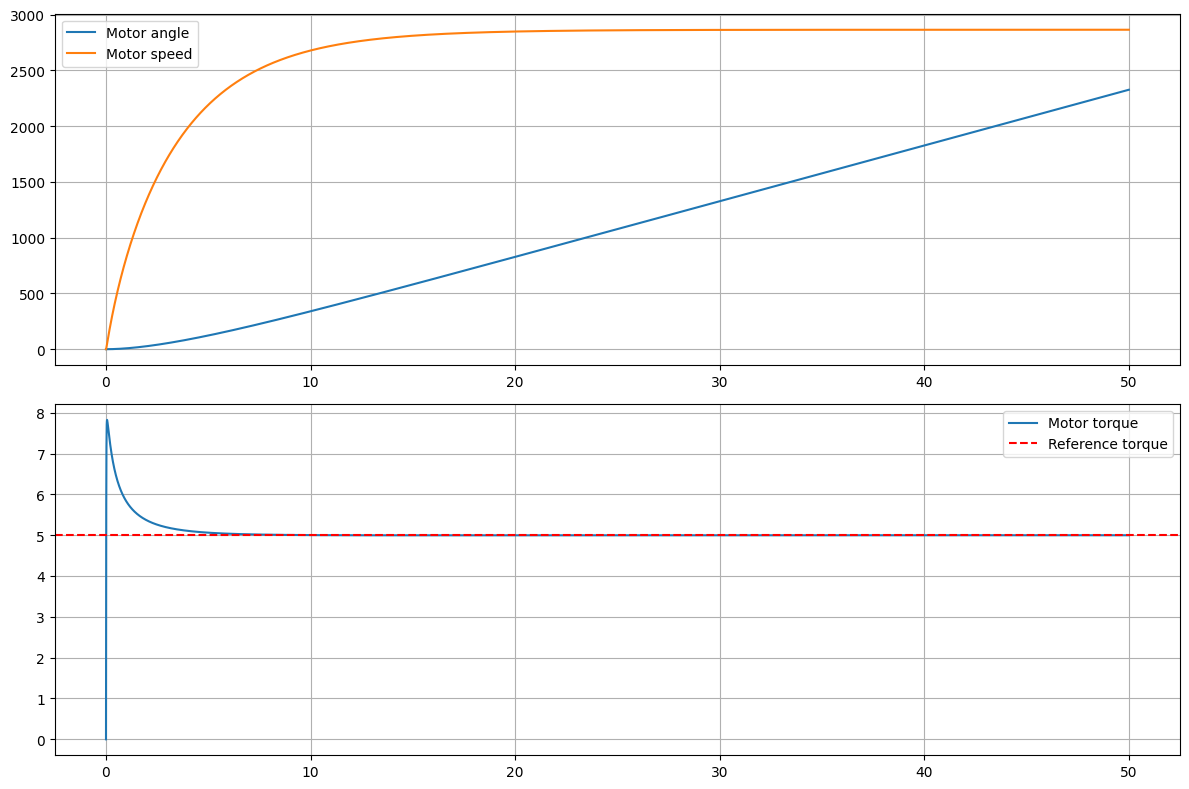

In [50]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(sol.t, sol.y[0,:], label='Motor angle')
ax1.plot(sol.t, np.rad2deg(sol.y[1,:]), label='Motor speed')
ax1.legend(); ax1.grid()
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(sol.t, sol.y[2,:] * schiffer_motor.Kt, label='Motor torque')
ax2.axhline(y=5, color='r', linestyle='--', label='Reference torque')
ax2.legend(); ax2.grid()
plt.tight_layout()
plt.show()